# TP1 - Part2 : Panorama
## Computer Vision - MID 2
### Benhalima Ahmed Youcef

In [55]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import networkx as nx

In [109]:
def read_img(img_path, quality=50, resize_ratio=1):
    # Load the image
    img = cv2.imread(img_path)
    if quality == 100:
        return img
    if resize_ratio != 1:
        img = cv2.resize(img, None, fx=resize_ratio, fy=resize_ratio)
    # Compress the image
    _, buffer = cv2.imencode(".jpg", img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    # Decode the buffer back into an image
    return cv2.imdecode(buffer, cv2.IMREAD_COLOR)

# Idea : Creating a panorama from two images

In the context of creating image panoramas, homographies are used to align multiple images of the same scene taken from different viewpoints. The process generally involves the following steps:

1. **Feature Detection**: Detect distinctive features in each image. These features should be invariant to scale, orientation, and lighting changes to some extent.

2. **Feature Matching**: Find matches between features in different images. This can be done using various methods, such as nearest-neighbor matching (knn).

3. **Homography Estimation**: Once matching features are found, a homography (a projective transformation, or a 3x3 matrix in the case of 2D images) can be estimated by complex methods like RANSAC. This homography represents the transformation from one image to the other.

4. **Image Warping**: Use the estimated homography to warp one image onto the other. This involves changing the coordinates of each pixel in one image according to the homography to align it with the second image.

This function, `gen_2imgs_panorama`, is used to generate a panorama from two images given a homography matrix that represents the transformation from the second image to the first. The function creates a panorama by warping the images to a common space and then combining them together. The use of a mask ensures that the second image is pasted onto the panorama only at the locations where it is defined.

Here's a detailed breakdown of the function:

1. The function takes three parameters: `I1`, `I2`, and `homography`. `I1` and `I2` are the two input images, and `homography` is the transformation matrix from `I2` to `I1`.

2. The function first gets the size of the input images.

3. The function then gets the corners of the images and transforms the corners of the second image using the homography.

4. The function calculates the size of the resulting panorama by finding the minimum and maximum x and y coordinates of the transformed corners.

5. The function calculates the offset for the panorama, which is the amount the panorama needs to be shifted to include all parts of the images.

6. The function creates an empty panorama image of the calculated size.

7. The function creates a transformation matrix `M` for the panorama. This matrix shifts the images by the calculated offset.

8. The function warps the input images to the panorama space using the `cv2.warpPerspective` function. The first image is warped using the matrix `M`, and the second image is warped using the product of `M` and the homography.

9. The function creates a mask of the second image. The mask is a binary image where the pixels corresponding to the second image are True and the rest are False.

10. The function pastes the second image onto the panorama using the mask. The pixels of the panorama where the mask is True are set to the corresponding pixels of the second image.

11. The function pastes the first image onto the panorama at the locations where the mask is False.

12. Finally, the function returns the created panorama.

In [111]:
def gen_2imgs_panorama(I1, I2, homography):
    # Get size of input images
    h1, w1 = I1.shape[:2]
    h2, w2 = I2.shape[:2]

    # Get the corners of the images
    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # Transform the corners of the second image
    corners2_transformed = cv2.perspectiveTransform(corners2, homography)

    # Get the size of the resulting panorama
    x_min = min(np.min(corners1[:, :, 0]), np.min(corners2_transformed[:, :, 0]))
    x_max = max(np.max(corners1[:, :, 0]), np.max(corners2_transformed[:, :, 0]))
    y_min = min(np.min(corners1[:, :, 1]), np.min(corners2_transformed[:, :, 1]))
    y_max = max(np.max(corners1[:, :, 1]), np.max(corners2_transformed[:, :, 1]))

    # Get the offset for the panorama
    offset_x = int(min(0, x_min))
    offset_y = int(min(0, y_min))

    # Get the size of the panorama
    width_panorama = int(x_max - x_min)
    height_panorama = int(y_max - y_min)

    # Create the panorama image
    panorama = np.zeros((height_panorama, width_panorama, 3), dtype=np.uint8)

    # Create the transformation matrix for the panorama
    M = np.array([[1, 0, -offset_x], [0, 1, -offset_y], [0, 0, 1]], dtype=np.float32)

    # Warp the images to create the panorama
    I1_transformed = cv2.warpPerspective(I1, M, (width_panorama, height_panorama))
    I2_transformed = cv2.warpPerspective(
        I2, np.dot(M, homography), (width_panorama, height_panorama)
    )

    # Create a mask of the second image
    mask = np.sum(I2_transformed, axis=2) > 0

    # Paste the second image onto the panorama
    panorama[mask] = I2_transformed[mask]

    # Paste the first image onto the panorama
    panorama[np.logical_not(mask)] = I1_transformed[np.logical_not(mask)]

    return panorama

This function, `gen_transform`, is used to generate a transformation matrix (homography) between two images. The estimated homography is used to warp one of the images to the coordinate system of the other, allowing them to be combined into a single image. The use of multiple methods of detecting features (ORB and SIFT) helps to ensure that the estimated homography is reliable.

Here's a detailed breakdown of the function:

1. The function takes two images `I1` and `I2` as input, along with several optional parameters that control the feature detection and homography estimation process.

2. The function first converts the input images to grayscale.

3. The function then loops over the methods specified in the `methods` parameter. For each method, it creates a feature detector and descriptor using either ORB or SIFT, depending on the method.

4. The function detects and computes descriptors for the grayscale images using the created detector and descriptor.

5. The function matches the descriptors of the two images using a BFMatcher. The norm type of the matcher depends on the method.

6. The function applies a ratio test to filter out bad matches. Only matches where the distance of the first match is less than `keepPercent` times the distance of the second match are kept.

7. The function gets the points corresponding to the good matches.

8. The function estimates a homography from the matched points using the RANSAC algorithm. The reprojection threshold, maximum number of iterations, and confidence for RANSAC are specified by the parameters `ransacReprojThreshold`, `maxIters`, and `confidence`, respectively.

9. If there are not enough matched points to estimate a homography, the function prints a message and continues with the next method.

10. The function calculates the number of inliers, which are the matched points that fit the estimated homography.

11. If the number of inliers is greater than or equal to `inliers_tresh`, the function returns the estimated homography.

12. If no homography could be estimated that satisfies the inlier threshold, the function returns `None`.


In [112]:
def gen_transform(
    I1, I2,
    maxFeatures=1000,
    keepPercent=0.75,
    ransacReprojThreshold=5.0,
    maxIters=5000,
    confidence=0.999,
    inliers_tresh=30,
    methods = ["orb", "sift"]
):
    # Convert images to grayscale
    gI1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
    gI2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

    for method in methods:
        # Create detector and descriptor
        if (method == "orb"): orb = cv2.ORB_create(maxFeatures)
        else: orb = cv2.xfeatures2d.SIFT_create(maxFeatures)

        # Detect and compute descriptors for the first and second images
        P1, F1 = orb.detectAndCompute(gI1, None)
        P2, F2 = orb.detectAndCompute(gI2, None)

        if (method == "orb"): bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        else: bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = bf.knnMatch(F2, F1, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < keepPercent*n.distance:
                good.append(m)
        matches = good

        # Get the matching points
        matchedPoints2 = np.float64([P2[match.queryIdx].pt for match in matches])
        matchedPoints1 = np.float64([P1[match.trainIdx].pt for match in matches])

        # Estimate the transformation
        if len(matchedPoints2) >= 4 and len(matchedPoints1) >= 4:
            M, mask = cv2.findHomography(
                matchedPoints2,
                matchedPoints1,
                cv2.RANSAC,
                ransacReprojThreshold=ransacReprojThreshold,
                maxIters=maxIters,
                confidence=confidence,
            )
        else:
            print(f"\t\tNot enough points to calculate Homography using {method}")
            continue

        # Calculate inliers
        num_inliers = np.sum(mask)
        
        if num_inliers >= inliers_tresh:
            return M

    return None

# Exo 2 : Panorama of two images

## Campus - Manual feature matching done by hand

In the provided code, the homography is estimated manually by providing corresponding points in both images. In a more automated system, steps 1 and 2 would be performed by a feature detection and matching algorithm.

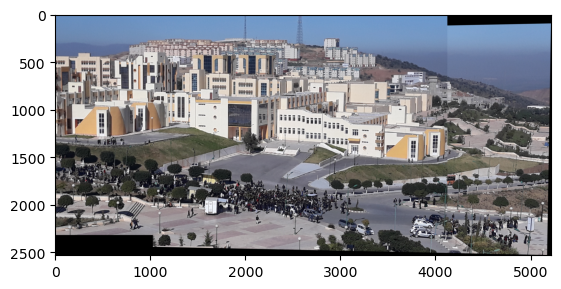

SVDecomp:
W:
 [[1.05157736e+03]
 [9.84372427e-01]
 [8.93000305e-04]]
U:
 [[ 9.84682436e-01  1.74354883e-01  9.35427836e-04]
 [ 1.74354799e-01 -9.84682880e-01  1.71215342e-04]
 [ 9.50952007e-04 -5.49640729e-06 -9.99999548e-01]]
Vt:
 [[ 8.61302935e-04  1.63985344e-04  9.99999616e-01]
 [ 1.85786751e-01 -9.82590089e-01  1.11169999e-06]
 [ 9.82589712e-01  1.85786679e-01 -8.76774032e-04]]


In [123]:
def manual_panorama_campus():
    # Read images
    I1 = cv2.imread("images/campus_01.jpg")
    I2 = cv2.imread("images/campus_02.jpg")

    # Convert images to grayscale
    gI1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
    gI2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

    # Manual feature matching done by hand (paint application)
    P1 = [(1450, 428), (1155, 2291), (2495, 1738), (2613, 313)]
    P2 = [(438, 256), (133, 2160), (1522, 1580), (1630, 160)]

    # Get the matching points
    matchedPoints2 = np.float32(P2)
    matchedPoints1 = np.float32(P1)

    # Estimate the transformation
    M, _ = cv2.findHomography(matchedPoints2, matchedPoints1, cv2.RANSAC, 5.0)

    # Warp the second image onto the first image to create a panorama
    h1, w1 = gI1.shape
    h2, w2 = gI2.shape

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    corners2_transformed = cv2.perspectiveTransform(corners2, M)
    corners = np.concatenate((corners1, corners2_transformed), axis=0)

    x_min, y_min = np.int32(corners.min(axis=0).ravel())
    x_max, y_max = np.int32(corners.max(axis=0).ravel())

    transformed_offset = (-x_min, -y_min)
    transformed_image = cv2.warpPerspective(I2, M, (x_max - x_min, y_max - y_min))
    transformed_image[
        transformed_offset[1] : h1 + transformed_offset[1],
        transformed_offset[0] : w1 + transformed_offset[0],
    ] = I1

    # Display the resulting panorama
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.show()

    W, U, Vt = cv2.SVDecomp(M)

    print("SVDecomp:")
    print("W:\n", W)
    print("U:\n", U)
    print("Vt:\n", Vt)

manual_panorama_campus()

## Campus - Automatic

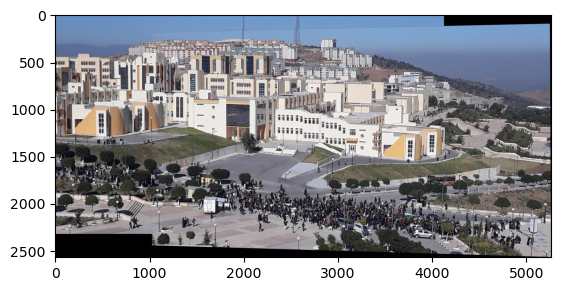

In [113]:
I1 = read_img("images/campus_01.jpg", quality=100, resize_ratio=1)
I2 = read_img("images/campus_02.jpg", quality=100, resize_ratio=1)
homography = gen_transform(I1, I2)
panorama = gen_2imgs_panorama(I1, I2, homography)
# Display the resulting panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()

## Case 1

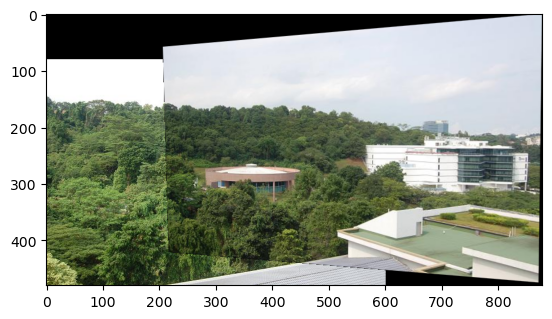

In [116]:
I1 = read_img("images/case1/1.JPG", quality=100, resize_ratio=1)
I2 = read_img("images/case1/2.JPG", quality=100, resize_ratio=1)
homography = gen_transform(I1, I2)
panorama = gen_2imgs_panorama(I1, I2, homography)
# Display the resulting panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()

## Case 2

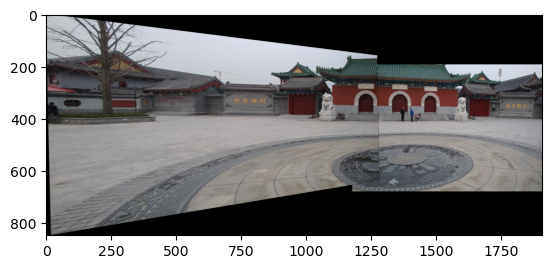

In [118]:
I1 = read_img("images/case2/3.JPG", quality=100, resize_ratio=1)
I2 = read_img("images/case2/2.JPG", quality=100, resize_ratio=1)
homography = gen_transform(I1, I2)
panorama = gen_2imgs_panorama(I1, I2, homography)
# Display the resulting panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()

# Idea : Creating a panorama from multiple images

In the context of creating a panorama from multiple images, each image can be considered as a node in a graph, and the transformation from one image to another can be considered as an edge. The weight of each edge can be determined by the quality of the transformation which is the number of inliers after applying a RANSAC algorithm for homography estimation.

A Maximum Spanning Tree (Arbre Couvrant Maximal - Théorie des graphes) is a subset of the edges of a connected, edge-weighted undirected graph that connects all the vertices together, without any cycles and with the maximum possible total edge weight. 

When creating a panorama, we want to use the transformations that are the most reliable, i.e., the ones with the highest weights (or the highest quality). By constructing a maximum spanning tree, we are ensuring that we are using the most reliable transformations to stitch the images together, because the MST will include the edges with the highest weights.

This approach also avoids cycles, which could lead to inconsistencies in the transformations. For example, if we have a cycle of transformations that takes us from image A to image B, then to image C, and then back to image A, the final transformation might not perfectly align with the original image A due to errors in the transformations. By using a MST, we avoid such cycles and thus avoid these potential inconsistencies.

In [67]:
def showGraph(G):
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_family="sans-serif")

    edge_labels = nx.get_edge_attributes(G, "inliers")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis("off")
    plt.show()

This function, `get_transform_graph`, is used to create a directed graph from a list of transformations. This function is part of a larger program for generating images panorama, where the graph represents a set of images (nodes) and transformations between them (edges). The `inliers` attribute on each edge represent the quality of the transformation, with a higher number of inliers indicating a better fit.

In [68]:
def get_transform_graph(edges, weight_coef=1):
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph from your list
    for edge in edges:
        G.add_node(edge["id1"], id=edge["id1"], img=edge["img1"])
        G.add_node(edge["id2"], id=edge["id2"], img=edge["img2"])
        G.add_edge(
            edge["id1"],
            edge["id2"],
            inliers=edge["inliers"] * weight_coef,
            M=edge["M"],
            id1=edge["id1"],
            img1=edge["img1"],
            img1file=edge["img1file"],
            id2=edge["id2"],
            img2=edge["img2"],
            img2file=edge["img2file"],
        )
        print(f"Added edge from {edge['id1']} to {edge['id2']} with inliers {edge['inliers'] * weight_coef}")

    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    return G

This function, `warp_imgs_panorama`, is used to create a panorama from a set of images by applying a set of homographies (transformations) to each image and stitching them together.

Here's a detailed breakdown of the function:

1. The function takes two parameters: `images` and `homographies`. `images` is a list of images to be stitched together, and `homographies` is a list of transformation matrices for each image.

2. The function first computes the bounding box for each transformed image. It does this by transforming the corners of each image using the corresponding homography and then computing the bounding box of the transformed corners.

3. The function then computes the bounding box that contains all the individual bounding boxes. This is done by finding the minimum and maximum x and y coordinates across all bounding boxes.

4. A blank image (named `result`) is created with the size of the overall bounding box. This image will be used to hold the final panorama.

5. A translation matrix `th` is created to shift the images so that they fit within the overall bounding box.

6. The function then iterates over each image. For each image, it combines the corresponding homography with the translation matrix and applies the resulting transformation to the image using the `cv2.warpPerspective` function. The transformed image is then copied into the corresponding location in the blank image.

7. After all images have been processed, the function prints a message indicating that the panorama has been created and returns the final panorama image.

In [69]:
def warp_imgs_panorama(images, homographies):
    # Compute the bounding box for each transformed image
    bounding_boxes = []
    for i in range(len(images)):
        height, width = images[i].shape[:2]
        corners = np.array(
            [[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]
        )
        corners = cv2.perspectiveTransform(np.float64([corners]), homographies[i])
        corners = corners.astype(np.float32)
        bounding_boxes.append(cv2.boundingRect(corners))

    # Compute the bounding box that contains all the bounding boxes
    x_min = min(box[0] for box in bounding_boxes)
    y_min = min(box[1] for box in bounding_boxes)
    x_max = max(box[0] + box[2] for box in bounding_boxes)
    y_max = max(box[1] + box[3] for box in bounding_boxes)

    print(f"Bounding box for panorama: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

    # Create a blank image that has the size of the bounding box
    result = np.zeros((y_max - y_min, x_max - x_min, 3), dtype=np.uint8)

    th = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float64)
    # Apply each transformation and copy the result to the corresponding location in the blank image
    for i in range(len(images)):
        # Combine the homographies
        pth = th @ homographies[i]

        # Apply the transformation to the image
        warped = cv2.warpPerspective(
            images[i],
            pth,
            (x_max - x_min, y_max - y_min),
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_CONSTANT,
        )

        print(f"Applied transformation to image {i}")

        # Copy the result to the corresponding location in the blank image
        result = cv2.max(result, warped)

    print("Finished creating panorama")
    return result

This function, `gen_panorama`, is used to generate a panorama from a set of images and transformations. The use of a maximum spanning tree ensures that the panorama is created using the most reliable transformations.

Here's a detailed breakdown of the function:

1. The function takes two parameters: `transforms` and `root`. `transforms` is a list of transformations for each image, and `root` is an optional parameter that specifies the root of the maximum spanning tree. If `root` is not provided or is not in the tree, the function uses the smallest node as the root.

2. The function first generates a directed graph from the transformations using the `get_transform_graph` function. It then computes the maximum spanning tree of the graph using the `nx.maximum_spanning_tree` function.

3. The function then initializes a stack for depth-first search (DFS) and a set to store the visited nodes. It also initializes two lists: `homographies` and `images`. The `homographies` list will store the transformation matrices for each image, and the `images` list will store the images themselves.

4. The function then performs a DFS on the tree. For each node, it computes the transformation matrix by multiplying the matrix of the current edge with the parent matrix. It then appends the matrix and the corresponding image to the `homographies` and `images` lists, respectively.

5. After all nodes have been visited, the function calls the `warp_imgs_panorama` function to create the panorama from the images and homographies.

6. Finally, the function returns the created panorama.


In [70]:
def gen_panorama(transforms, root=None):

    print("Generating panorama...")

    print("Generating graph...")
    G = get_transform_graph(transforms, weight_coef=1)
    showGraph(G)

    print("Computing maximum spanning tree...")
    # Compute the maximum spanning tree
    T = nx.maximum_spanning_tree(G.to_undirected(), weight="inliers")
    showGraph(T)
    
    # Find the root of the tree
    if root is None or root not in T.nodes:
        root = min(T.nodes)
    print(f"Root of the tree: {root}")

    # Initialize a stack for DFS
    stack = [(root, np.eye(3))]

    # Initialize a set to store the visited nodes
    visited = set()

    homographies = [np.eye(3)]
    images = [G.nodes[root]["img"]]

    print("Computing homographies...")
    while stack:
        # Pop a node from the stack
        node, parent_matrix = stack.pop()
        if node not in visited:
            # Add the node to the visited set
            visited.add(node)

            # Multiply the matrix of the current edge with the parent matrix
            for child in T.neighbors(node):
                if child not in visited:
                    img2 = G.nodes[child]["img"]

                    transform = G.edges[node, child]
                    edge_matrix = parent_matrix @ transform["M"]

                    print(f"Computed homography for node {child} with parent {node}")

                    homographies.append(edge_matrix)
                    images.append(img2)

                    # Add the child and the updated matrix to the stack
                    stack.append((child, edge_matrix))
    return warp_imgs_panorama(images, homographies)

This function, `gen_transforms`, is used to generate transformations between pairs of images in a given folder. The transformations are used to align the images before stitching them together.

Here's a detailed breakdown of the function:

1. The function takes several parameters, including the folder containing the images, parameters for feature detection and matching, and parameters for homography estimation.

2. The function first gets a list of all JPEG images in the specified folder.

3. The function then initializes an empty list `transforms` to store the transformations.

4. The function then iterates over each pair of images in the folder. For each pair, it loads the images, converts them to grayscale, and then performs feature detection and matching.

5. Feature detection and matching is performed using either the ORB or SIFT method, as specified by the `methods` parameter. The function creates a feature detector and descriptor, detects and computes descriptors for both images, and then matches the descriptors using the BFMatcher class.

6. The function then applies a ratio test to filter out bad matches. The ratio test compares the distance of the best match to the distance of the second best match for each feature. If the ratio is less than the `keepPercent` parameter, the match is considered good.

7. The function then estimates the transformation between the matched points using the RANSAC algorithm. The transformation is a homography.

8. The function then calculates the number of inliers, which are matches that fit the estimated transformation well. If the number of inliers is above a certain threshold, the function adds the transformation to the `transforms` list.

9. After all pairs of images have been processed, the function returns the list of transformations.


In [95]:
def gen_transforms(
    folder,
    maxFeatures=1000,
    keepPercent=0.75,
    ransacReprojThreshold=5.0,
    maxIters=5000,
    confidence=0.999,
    inliers_tresh=30,
    quality=50,
    resize_ratio=1,
    methods = ["orb", "sift"]
):
    # Get the list of images
    images = [f for f in os.listdir(folder) if f.endswith(".JPG") or f.endswith(".jpg")]

    print(f"Found {len(images)} images in the folder")

    transforms = []

    # Loop through the images
    for i in range(len(images)):
        # Load the first image and convert it to grayscale
        I1 = read_img(os.path.join(folder, images[i]), quality=quality, resize_ratio=resize_ratio) if quality != 100 else cv2.imread(os.path.join(folder, images[i]))
        gI1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)

        for j in range(len(images)):
            if i==j: continue

            # Load the next image and convert it to grayscale
            I2 = read_img(os.path.join(folder, images[j]), quality=quality, resize_ratio=resize_ratio) if quality != 100 else cv2.imread(os.path.join(folder, images[j]))
            gI2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

            print(f"Processing {images[i]} and {images[j]}:")

            for method in methods:
                # Create detector and descriptor
                if (method == "orb"): orb = cv2.ORB_create(maxFeatures)
                else: orb = cv2.xfeatures2d.SIFT_create(maxFeatures)

                # Detect and compute descriptors for the first and second images
                P1, F1 = orb.detectAndCompute(gI1, None)
                P2, F2 = orb.detectAndCompute(gI2, None)

                print(f"\tDetected and computed descriptors for {images[i]} and {images[j]} using {method}")

                if (method == "orb"): bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
                else: bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
                matches = bf.knnMatch(F2, F1, k=2)

                # Apply ratio test
                good = []
                for m,n in matches:
                    if m.distance < keepPercent*n.distance:
                        good.append(m)
                matches = good

                print(f"\t\tFound {len(matches)} good matches")

                # Get the matching points
                matchedPoints2 = np.float64([P2[match.queryIdx].pt for match in matches])
                matchedPoints1 = np.float64([P1[match.trainIdx].pt for match in matches])

                # Estimate the transformation
                if len(matchedPoints2) >= 4 and len(matchedPoints1) >= 4:
                    M, mask = cv2.findHomography(
                        matchedPoints2,
                        matchedPoints1,
                        cv2.RANSAC,
                        ransacReprojThreshold=ransacReprojThreshold,
                        maxIters=maxIters,
                        confidence=confidence,
                    )
                else:
                    print(f"\t\tNot enough points to calculate Homography for {images[i]} and {images[j]} using {method}")
                    continue

                # Calculate inliers
                num_inliers = np.sum(mask)
                print(f"\t\tFound {num_inliers} inliers out of {len(matches)} matches for {method}")
                
                if num_inliers >= inliers_tresh:
                    transforms.append(
                        {
                            "img1file": images[i],
                            "img1": I1,
                            "id1": i,
                            "img2file": images[j],
                            "img2": I2,
                            "id2": j,
                            "M": M,
                            "inliers": num_inliers,
                        }
                    )
                    print(f"\t\tAdded transform between {images[i]} and {images[j]}")
                    break  # Break the loop if the number of inliers is above the threshold

    print(f"\tGenerated {len(transforms)} transforms")
    return transforms

# Exo 3 : Panorama of multiple images (same scene)

## Case 1

Found 5 images in the folder
Processing 2.JPG and 1.JPG:
	Detected and computed descriptors for 2.JPG and 1.JPG using orb
		Found 239 good matches
		Found 203 inliers out of 239 matches for orb
		Added transform between 2.JPG and 1.JPG
Processing 2.JPG and 3.JPG:


	Detected and computed descriptors for 2.JPG and 3.JPG using orb
		Found 681 good matches
		Found 639 inliers out of 681 matches for orb
		Added transform between 2.JPG and 3.JPG
Processing 2.JPG and 5.JPG:
	Detected and computed descriptors for 2.JPG and 5.JPG using orb
		Found 118 good matches
		Found 104 inliers out of 118 matches for orb
		Added transform between 2.JPG and 5.JPG
Processing 2.JPG and 4.JPG:
	Detected and computed descriptors for 2.JPG and 4.JPG using orb
		Found 475 good matches
		Found 444 inliers out of 475 matches for orb
		Added transform between 2.JPG and 4.JPG
Processing 1.JPG and 2.JPG:
	Detected and computed descriptors for 1.JPG and 2.JPG using orb
		Found 249 good matches
		Found 227 inliers out of 249 matches for orb
		Added transform between 1.JPG and 2.JPG
Processing 1.JPG and 3.JPG:
	Detected and computed descriptors for 1.JPG and 3.JPG using orb
		Found 49 good matches
		Found 36 inliers out of 49 matches for orb
	Detected and computed descriptors for

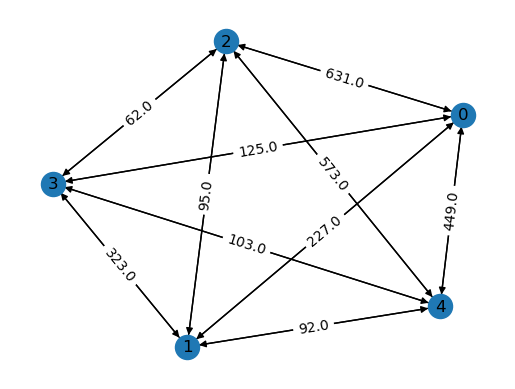

Computing maximum spanning tree...


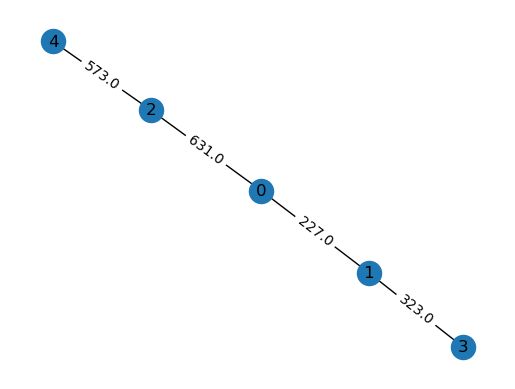

Root of the tree: 0
Computing homographies...
Computed homography for node 2 with parent 0
Computed homography for node 1 with parent 0
Computed homography for node 3 with parent 1
Computed homography for node 4 with parent 2
Bounding box for panorama: x_min=-411, y_min=-22, x_max=876, y_max=724
Applied transformation to image 0
Applied transformation to image 1
Applied transformation to image 2
Applied transformation to image 3
Applied transformation to image 4
Finished creating panorama


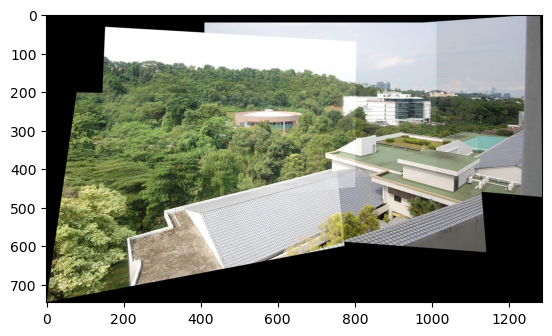

In [100]:
folder = "images/case1/"
transforms = gen_transforms(
    folder,
    maxFeatures=2000,
    inliers_tresh=50,
    quality=100,
)
panorama = gen_panorama(transforms, root=0)
# Display the resulting panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()

In [76]:
cv2.imwrite("case1.jpg", panorama)

True

## Case 2

Found 5 images in the folder
Processing 2.JPG and 1.JPG:
	Detected and computed descriptors for 2.JPG and 1.JPG using orb


		Found 174 good matches
		Found 135 inliers out of 174 matches for orb
		Added transform between 2.JPG and 1.JPG
Processing 2.JPG and 3.JPG:
	Detected and computed descriptors for 2.JPG and 3.JPG using orb
		Found 43 good matches
		Found 18 inliers out of 43 matches for orb
	Detected and computed descriptors for 2.JPG and 3.JPG using sift
		Found 195 good matches
		Found 108 inliers out of 195 matches for sift
		Added transform between 2.JPG and 3.JPG
Processing 2.JPG and 5.JPG:
	Detected and computed descriptors for 2.JPG and 5.JPG using orb
		Found 12 good matches
		Found 6 inliers out of 12 matches for orb
	Detected and computed descriptors for 2.JPG and 5.JPG using sift
		Found 18 good matches
		Found 5 inliers out of 18 matches for sift
Processing 2.JPG and 4.JPG:
	Detected and computed descriptors for 2.JPG and 4.JPG using orb
		Found 14 good matches
		Found 5 inliers out of 14 matches for orb
	Detected and computed descriptors for 2.JPG and 4.JPG using sift
		Found 22 good matc

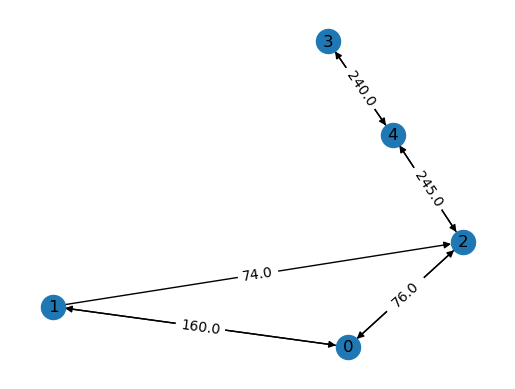

Computing maximum spanning tree...


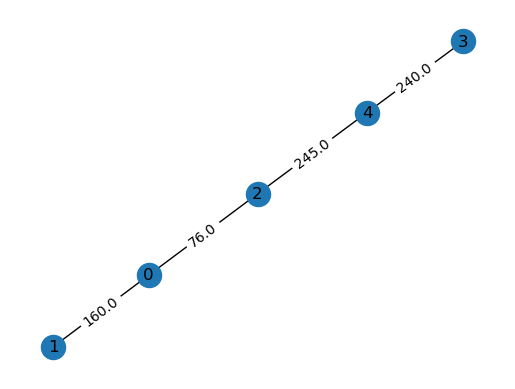

Root of the tree: 2
Computing homographies...
Computed homography for node 4 with parent 2
Computed homography for node 0 with parent 2
Computed homography for node 1 with parent 0
Computed homography for node 3 with parent 4
Bounding box for panorama: x_min=-14070, y_min=-2089, x_max=7809, y_max=4155
Applied transformation to image 0
Applied transformation to image 1
Applied transformation to image 2
Applied transformation to image 3
Applied transformation to image 4
Finished creating panorama


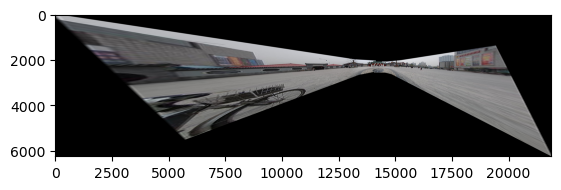

In [97]:
folder = "images/case2/"
transforms = gen_transforms(
    folder,
    maxFeatures=2000,
    inliers_tresh=50,
    quality=100,
)
panorama = gen_panorama(transforms, root=2)
# Display the resulting panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()

In [49]:
cv2.imwrite("case2.jpg", panorama)

True

## Case 3

Found 10 images in the folder
Processing 05.jpg and 10.jpg:
	Detected and computed descriptors for 05.jpg and 10.jpg using orb
		Found 6 good matches
		Found 4 inliers out of 6 matches for orb


	Detected and computed descriptors for 05.jpg and 10.jpg using sift
		Found 4 good matches
		Found 4 inliers out of 4 matches for sift
Processing 05.jpg and 03.jpg:
	Detected and computed descriptors for 05.jpg and 03.jpg using orb
		Found 90 good matches
		Found 78 inliers out of 90 matches for orb
		Added transform between 05.jpg and 03.jpg
Processing 05.jpg and 01.jpg:
	Detected and computed descriptors for 05.jpg and 01.jpg using orb
		Found 16 good matches
		Found 8 inliers out of 16 matches for orb
	Detected and computed descriptors for 05.jpg and 01.jpg using sift
		Found 27 good matches
		Found 19 inliers out of 27 matches for sift
Processing 05.jpg and 06.jpg:
	Detected and computed descriptors for 05.jpg and 06.jpg using orb
		Found 10 good matches
		Found 6 inliers out of 10 matches for orb
	Detected and computed descriptors for 05.jpg and 06.jpg using sift
		Found 7 good matches
		Found 5 inliers out of 7 matches for sift
Processing 05.jpg and 04.jpg:
	Detected and computed

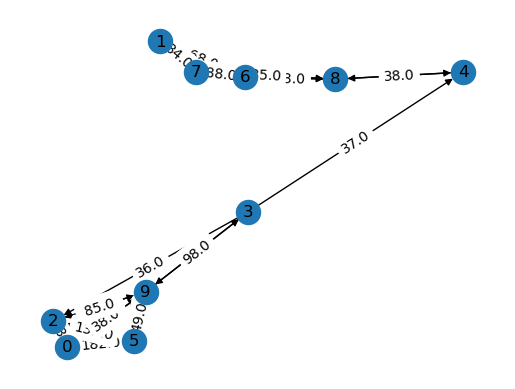

Computing maximum spanning tree...


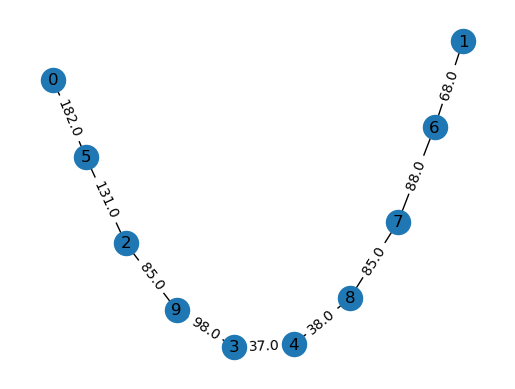

Root of the tree: 3
Computing homographies...
Computed homography for node 9 with parent 3
Computed homography for node 4 with parent 3
Computed homography for node 8 with parent 4
Computed homography for node 7 with parent 8
Computed homography for node 6 with parent 7
Computed homography for node 1 with parent 6
Computed homography for node 2 with parent 9
Computed homography for node 5 with parent 2
Computed homography for node 0 with parent 5
Bounding box for panorama: x_min=-3838, y_min=-1466, x_max=9787, y_max=4039
Applied transformation to image 0
Applied transformation to image 1
Applied transformation to image 2
Applied transformation to image 3
Applied transformation to image 4
Applied transformation to image 5
Applied transformation to image 6
Applied transformation to image 7
Applied transformation to image 8
Applied transformation to image 9
Finished creating panorama


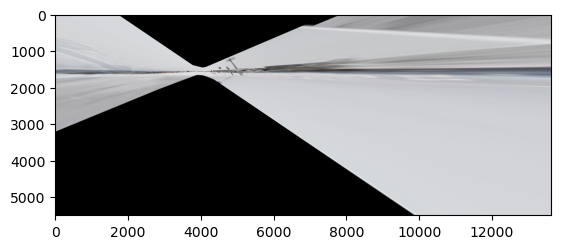

In [101]:
folder = "images/case3/"
transforms = gen_transforms(
    folder,
    maxFeatures=2000,
    inliers_tresh=30,
    quality=80,
    resize_ratio=0.3
)
panorama = gen_panorama(transforms, root=3)
# Display the resulting panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()

In [78]:
cv2.imwrite("case3.jpg", panorama)

True

This function, `gen_panoramas`, is used to generate panoramas from a set of transformations. The use of a maximum spanning tree ensures that the panorama is created using the most reliable transformations. The function generates multiple panoramas by repeating the process for each **connected component** of the graph of transformations.

Here's a detailed breakdown of the function:

1. The function takes two parameters: `transforms` and `root`. `transforms` is a list of transformations for each image, and `root` is an optional parameter that specifies the root of the maximum spanning tree. If `root` is not provided or is not in the tree, the function uses the smallest node as the root.

2. The function first generates a directed graph from the transformations using the `get_transform_graph` function. It then computes the maximum spanning tree of the graph using the `nx.maximum_spanning_tree` function.

3. The function then initializes a stack for depth-first search (DFS) and a set to store the visited nodes. It also initializes two lists: `homographies` and `images`. The `homographies` list will store the transformation matrices for each image, and the `images` list will store the images themselves.

4. The function then performs a DFS on the tree. For each node, it computes the transformation matrix by multiplying the matrix of the current edge with the parent matrix. It then appends the matrix and the corresponding image to the `homographies` and `images` lists, respectively.

5. After all nodes have been visited, the function removes the nodes of the maximum spanning tree from the graph.

6. The function then calls the `warp_imgs_panorama` function to create the panorama from the images and homographies. The created panorama is added to the `panoramas` list.

7. The function repeats the process until there are no nodes left in the graph.

8. Finally, the function returns the list of created panoramas.

In [102]:
def gen_panoramas(transforms, root=None):
    print("Generating panoramas...")

    # Generate the graph
    G = get_transform_graph(transforms, weight_coef=1)
    print(f"Generated graph with {len(G.nodes)} nodes and {len(G.edges)} edges")
    showGraph(G)

    panoramas = []

    while G.nodes:
        print("Computing maximum spanning tree...")
        # Compute the maximum spanning tree
        T = nx.maximum_spanning_tree(G.to_undirected(), weight="inliers")
        showGraph(T)
        print(f"Computed maximum spanning tree with {len(T.nodes)} nodes and {len(T.edges)} edges")
        
        # Find the root of the tree
        if root is None or root not in T.nodes:
            root = min(T.nodes)
        print(f"Root of the tree: {root}")

        # Initialize a stack for DFS
        stack = [(root, np.eye(3))]

        # Initialize a set to store the visited nodes
        visited = set()

        homographies = [np.eye(3)]
        images = [G.nodes[root]["img"]]

        print("Computing homographies...")
        while stack:
            # Pop a node from the stack
            node, parent_matrix = stack.pop()
            if node not in visited:
                # Add the node to the visited set
                visited.add(node)

                # Multiply the matrix of the current edge with the parent matrix
                for child in T.neighbors(node):
                    if child not in visited:
                        img2 = G.nodes[child]["img"]

                        transform = G.edges[node, child]
                        edge_matrix = parent_matrix @ transform["M"]

                        homographies.append(edge_matrix)
                        images.append(img2)

                        # Add the child and the updated matrix to the stack
                        stack.append((child, edge_matrix))
        print("Finished computing homographies")

        # Remove the nodes of the maximum spanning tree from the graph
        G.remove_nodes_from(visited)
        print(f"Removed {len(T.nodes)} nodes from the graph. Remaining nodes: {len(G.nodes)}")

        # Generate the panorama and add it to the list
        print("Generating panorama...")
        panorama = warp_imgs_panorama(images, homographies)
        panoramas.append(panorama)
        print("Panorama generated")

    print("Finished generating panoramas")
    return panoramas

# Exo 4 : Multiple panoramas of different scenes

## Case 4

Found 12 images in the folder


Processing 04.JPG and 12.JPG:
	Detected and computed descriptors for 04.JPG and 12.JPG using orb
		Found 10 good matches
		Found 4 inliers out of 10 matches for orb
	Detected and computed descriptors for 04.JPG and 12.JPG using sift
		Found 13 good matches
		Found 6 inliers out of 13 matches for sift
Processing 04.JPG and 03.JPG:
	Detected and computed descriptors for 04.JPG and 03.JPG using orb
		Found 492 good matches
		Found 459 inliers out of 492 matches for orb
		Added transform between 04.JPG and 03.JPG
Processing 04.JPG and 07.JPG:
	Detected and computed descriptors for 04.JPG and 07.JPG using orb
		Found 7 good matches
		Found 4 inliers out of 7 matches for orb
	Detected and computed descriptors for 04.JPG and 07.JPG using sift
		Found 12 good matches
		Found 5 inliers out of 12 matches for sift
Processing 04.JPG and 10.JPG:
	Detected and computed descriptors for 04.JPG and 10.JPG using orb
		Found 4 good matches
		Found 4 inliers out of 4 matches for orb
	Detected and computed

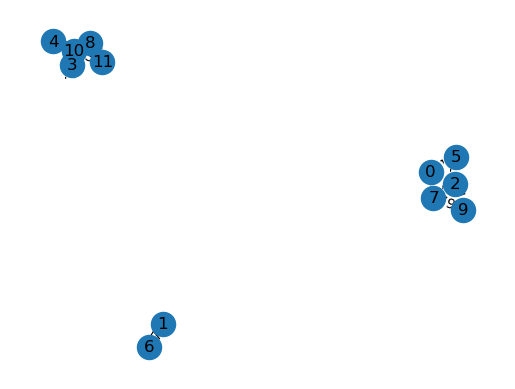

Computing maximum spanning tree...


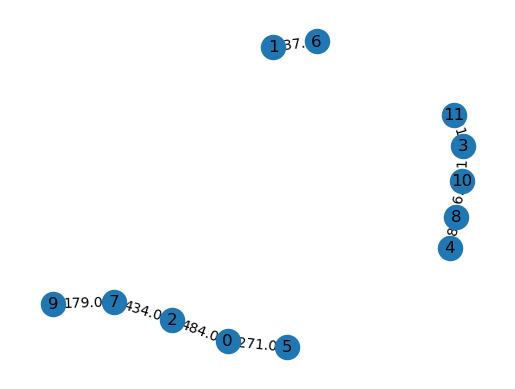

Computed maximum spanning tree with 12 nodes and 9 edges
Root of the tree: 3
Computing homographies...
Finished computing homographies
Removed 12 nodes from the graph. Remaining nodes: 7
Generating panorama...
Bounding box for panorama: x_min=-185, y_min=-59, x_max=1671, y_max=821
Applied transformation to image 0
Applied transformation to image 1
Applied transformation to image 2
Applied transformation to image 3
Applied transformation to image 4
Finished creating panorama
Panorama generated
Computing maximum spanning tree...


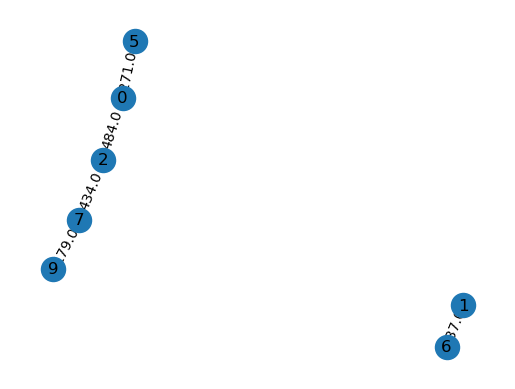

Computed maximum spanning tree with 7 nodes and 5 edges
Root of the tree: 0
Computing homographies...
Finished computing homographies
Removed 7 nodes from the graph. Remaining nodes: 2
Generating panorama...
Bounding box for panorama: x_min=-1854, y_min=-383, x_max=915, y_max=925
Applied transformation to image 0
Applied transformation to image 1
Applied transformation to image 2
Applied transformation to image 3
Applied transformation to image 4
Finished creating panorama
Panorama generated
Computing maximum spanning tree...


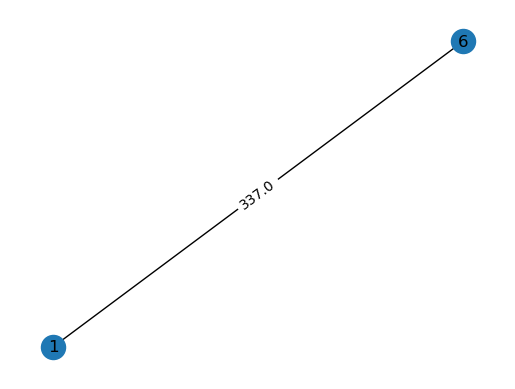

Computed maximum spanning tree with 2 nodes and 1 edges
Root of the tree: 1
Computing homographies...
Finished computing homographies
Removed 2 nodes from the graph. Remaining nodes: 0
Generating panorama...
Bounding box for panorama: x_min=-374, y_min=0, x_max=600, y_max=521
Applied transformation to image 0
Applied transformation to image 1
Finished creating panorama
Panorama generated
Finished generating panoramas


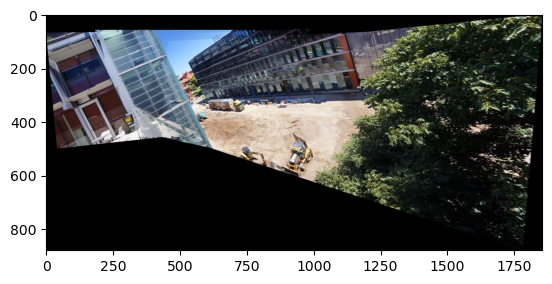

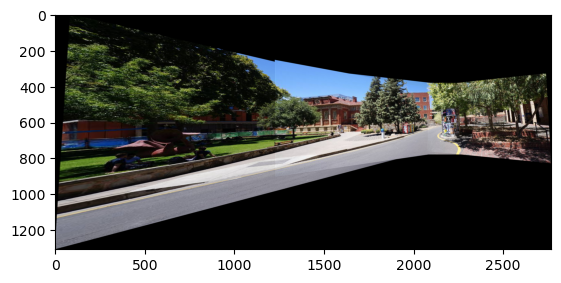

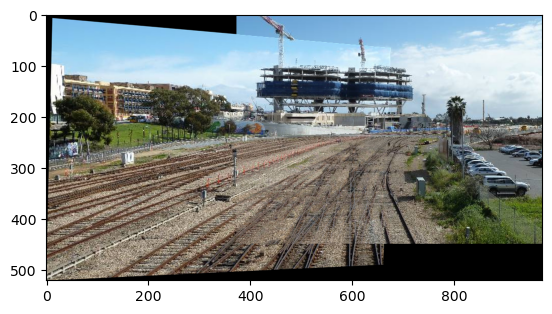

In [106]:
folder = "images/case4/"
transforms = gen_transforms(
    folder,
    maxFeatures=2000,
    inliers_tresh=30,
    quality=70,
    resize_ratio=0.3,
)
panoramas = gen_panoramas(transforms, root=3)
for panorama in panoramas:
    # Display the resulting panorama
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.show()

In [108]:
for i in range(len(panoramas)):
    cv2.imwrite(f"case4_{i+1}.jpg", panoramas[i])